In [2]:
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
# Définition des tâches (durée, prédécesseurs)
tasks = [
    (2, []),        # 0 : Permis
    (7, []),        # 1 : Maçonnerie
    (3, [0, 1]),    # 2 : Charpente
    (1, [2]),       # 3 : Toiture
    (8, [0, 1]),    # 4 : Plomberie
    (2, [3, 4]),    # 5 : Façade
    (1, [3, 4]),    # 6 : Fenêtre
    (1, [3, 4]),    # 7 : Jardin
    (3, [6]),       # 8 : Plafonds
    (2, [8]),       # 9 : Peintures
    (1, [5, 9])     # 10 : Emménagement
]


# Nouvelle section

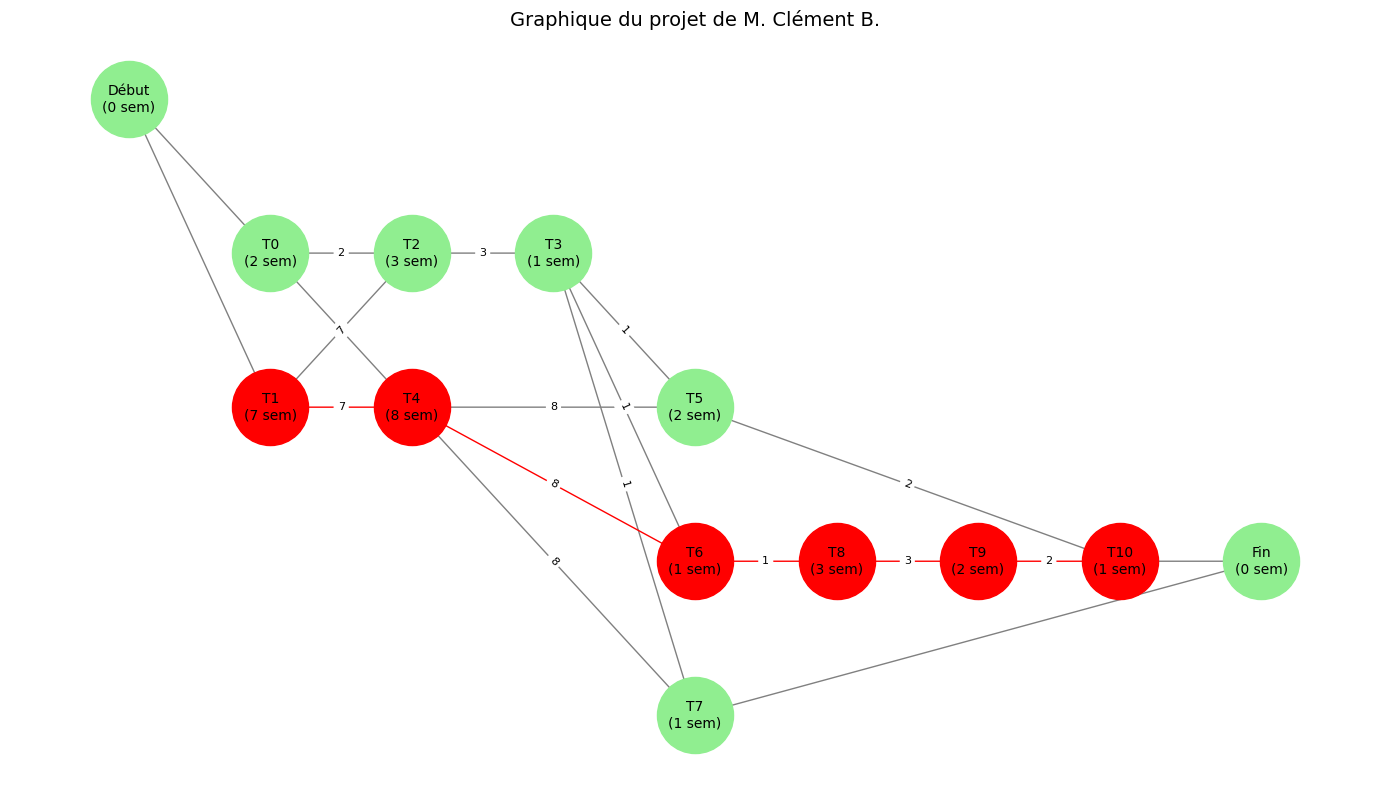

In [5]:
# Création du graphe orienté
G = nx.DiGraph()

# Ajout des nœuds et des arêtes avec durées comme poids
for i, (duration, preds) in enumerate(tasks):
    G.add_node(i, label=f"T{i}\n({duration} sem)")
    for p in preds:
        G.add_edge(p, i, weight=tasks[p][0])  # Poids basé sur la durée de la tâche source

# Ajout du nœud de début (prédecesseurs de 0 et 1) sans poids
G.add_node(-1, label="Début\n(0 sem)")
G.add_edge(-1, 0)  # Début to T0
G.add_edge(-1, 1)  # Début to T1

# Ajout du nœud de fin (successeurs de 7 et 10) sans poids
G.add_node(11, label="Fin\n(0 sem)")
G.add_edge(7, 11)  # Jardin to Fin
G.add_edge(10, 11) # Emménagement to Fin

# Manuel positioning to match hand-drawn layout
pos = {
    -1: (0, 5),    # Début
    0: (1, 4),     # T0 (Permis)
    1: (1, 3),     # T1 (Maçonnerie)
    2: (2, 4),     # T2 (Charpente)
    3: (3, 4),     # T3 (Toiture)
    4: (2, 3),     # T4 (Plomberie)
    5: (4, 3),     # T5 (Façade)
    6: (4, 2),     # T6 (Fenêtre)
    7: (4, 1),     # T7 (Jardin)
    8: (5, 2),     # T8 (Plafond)
    9: (6, 2),     # T9 (Peintures)
    10: (7, 2),    # T10 (Emménagement)
    11: (8, 2)     # Fin
}

# Calcul des dates au plus tôt et au plus tard
def project(L):
    n = len(L)
    durations = [L[i][0] for i in range(n)]
    predecessors = [L[i][1] for i in range(n)]

    graph = {i: [] for i in range(n)}
    in_degree = [0] * n
    for i, preds in enumerate(predecessors):
        for p in preds:
            graph[p].append(i)
            in_degree[i] += 1

    queue = [i for i in range(n) if in_degree[i] == 0]
    topo_order = []
    while queue:
        node = queue.pop(0)
        topo_order.append(node)
        for succ in graph[node]:
            in_degree[succ] -= 1
            if in_degree[succ] == 0:
                queue.append(succ)

    earliest = [0] * n
    for i in topo_order:
        for j in graph[i]:
            earliest[j] = max(earliest[j], earliest[i] + durations[i])

    project_duration = max(earliest[i] + durations[i] for i in range(n))

    latest = [project_duration] * n
    for i in reversed(topo_order):
        if not graph[i]:
            latest[i] = project_duration - durations[i]
        for j in graph[i]:
            latest[i] = min(latest[i], latest[j] - durations[i])

    return earliest, latest, project_duration, topo_order

earliest, latest, project_duration, topo_order = project(tasks)
critical_tasks = [i for i in range(len(tasks)) if latest[i] == earliest[i]]

# Dessin du graphe
plt.figure(figsize=(14, 8))
# Draw non-critical nodes
non_critical_nodes = [n for n in G.nodes() if n not in critical_tasks and n not in [-1, 11]]
nx.draw_networkx_nodes(G, pos, nodelist=non_critical_nodes, node_color="lightgreen", node_size=3000)
# Draw critical nodes
nx.draw_networkx_nodes(G, pos, nodelist=critical_tasks, node_color="red", node_size=3000)
# Draw start and end nodes
nx.draw_networkx_nodes(G, pos, nodelist=[-1, 11], node_color="lightgreen", node_size=3000)
# Draw non-critical edges
non_critical_edges = [(u, v) for u, v in G.edges() if u not in critical_tasks or v not in critical_tasks]
nx.draw_networkx_edges(G, pos, edgelist=non_critical_edges, edge_color="gray", arrows=True, arrowstyle="->", arrowsize=20)
# Draw critical edges
critical_edges = [(u, v) for u, v in G.edges() if u in critical_tasks and v in critical_tasks]
nx.draw_networkx_edges(G, pos, edgelist=critical_edges, edge_color="red", arrows=True, arrowstyle="->", arrowsize=20)
# Labels for nodes
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10)
# Labels for edge weights (durations from source nodes), excluding Début and Fin edges
edge_weights = {}
for u, v in G.edges():
    if u != -1 and v != 11:  # Exclude edges from Début and to Fin
        edge_weights[(u, v)] = str(tasks[u][0])  # Durée propre de la tâche source
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=8, label_pos=0.5)  # Centered on edges
plt.title("Graphique du projet de M. Clément B.", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#6. Implémentation de la fonction
def project(L):
    n = len(L)
    durations = [L[i][0] for i in range(n)]
    predecessors = [L[i][1] for i in range(n)]

    # 1. Construire le graphe et le degré entrant
    from collections import defaultdict, deque

    graph = defaultdict(list)
    in_degree = [0] * n
    for i, preds in enumerate(predecessors):
        for p in preds:
            graph[p].append(i)
            in_degree[i] += 1

    # 2. Tri topologique
    queue = deque([i for i in range(n) if in_degree[i] == 0])
    topo_order = []
    while queue:
        node = queue.popleft()
        topo_order.append(node)
        for succ in graph[node]:
            in_degree[succ] -= 1
            if in_degree[succ] == 0:
                queue.append(succ)

    # 3. Date au plus tôt
    earliest = [0] * n
    for i in topo_order:
        for j in graph[i]:
            earliest[j] = max(earliest[j], earliest[i] + durations[i])

    project_duration = max(earliest[i] + durations[i] for i in range(n))
    print(earliest)

    # 4. Date au plus tard
    latest = [project_duration] * n
    for i in reversed(topo_order):
        if not graph[i]:  # tâche finale
            latest[i] = project_duration - durations[i]
        for j in graph[i]:
            latest[i] = min(latest[i], latest[j] - durations[i])
    print(latest)

    # 5. Résultat
    result = []
    for i in range(n):
        slack = latest[i] - earliest[i]
        result.append({
            "tâche": i,
            "DE (au plus tôt)": earliest[i],
            "slack (marge)": slack
        })

    return result, project_duration

In [ ]:
#Résultat du projet
résultat, durée = project(tasks)

for r in résultat:
    print(f"Tâche {r['tâche']} : DE = {r['DE (au plus tôt)']}, Slack = {r['slack (marge)']}")
print(f"Durée minimale du projet : {durée} semaines")

[0, 0, 7, 10, 7, 15, 15, 15, 16, 19, 21]
[5, 0, 11, 14, 7, 19, 15, 21, 16, 19, 21]
Tâche 0 : DE = 0, Slack = 5
Tâche 1 : DE = 0, Slack = 0
Tâche 2 : DE = 7, Slack = 4
Tâche 3 : DE = 10, Slack = 4
Tâche 4 : DE = 7, Slack = 0
Tâche 5 : DE = 15, Slack = 4
Tâche 6 : DE = 15, Slack = 0
Tâche 7 : DE = 15, Slack = 6
Tâche 8 : DE = 16, Slack = 0
Tâche 9 : DE = 19, Slack = 0
Tâche 10 : DE = 21, Slack = 0
Durée minimale du projet : 22 semaines
